In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import statsmodels.formula.api as smf
import lxml

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pd.options.display.float_format = '{:.4f}'.format

In [2]:
data = pd.read_csv('../raw_data/dreaddit-train.csv', parse_dates=True)
data_test = pd.read_csv('../raw_data/dreaddit-test.csv', parse_dates=True)

In [3]:
#data.columns.to_list()
cols_to_remove =  ['syntax_ari',
                   'syntax_fk_grade',
                   'lex_dal_max_pleasantness',
                   'lex_dal_max_activation',
                   'lex_dal_max_imagery',
                   'lex_dal_min_pleasantness',
                   'lex_dal_min_activation',
                   'lex_dal_min_imagery',
                   'lex_dal_avg_activation',
                   'lex_dal_avg_imagery',
                   'lex_dal_avg_pleasantness',
                   'sentiment',
                   'post_id']
data.drop(columns=cols_to_remove, inplace=True)

In [4]:
data['domain'] = data['subreddit'].map({'domesticviolence': 'abuse',
                                       'survivorsofabuse': 'abuse',
                                       'anxiety': 'anxiety',
                                       'stress': 'anxiety',
                                       'almosthomeless': 'ﬁnancial',
                                       'assistance': 'ﬁnancial',
                                       'food_pantry': 'ﬁnancial',
                                       'homeless':'ﬁnancial',
                                       'ptsd':'ptsd',
                                       'relationships':'social'
                                       })

In [5]:
data.isnull().sum().sort_values(ascending=True)
#no missing values in the data set

subreddit               0
lex_liwc_space          0
lex_liwc_motion         0
lex_liwc_relativ        0
lex_liwc_focusfuture    0
                       ..
lex_liwc_conj           0
lex_liwc_adverb         0
lex_liwc_auxverb        0
social_num_comments     0
domain                  0
Length: 104, dtype: int64

In [6]:
data.dtypes

subreddit               object
sentence_range          object
text                    object
id                       int64
label                    int64
                        ...   
lex_liwc_Parenth       float64
lex_liwc_OtherP        float64
social_upvote_ratio    float64
social_num_comments      int64
domain                  object
Length: 104, dtype: object

In [7]:
data['social_date'] = data['social_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
data = data.drop(columns='social_timestamp')

#### check distribution of characters within each Reddit post

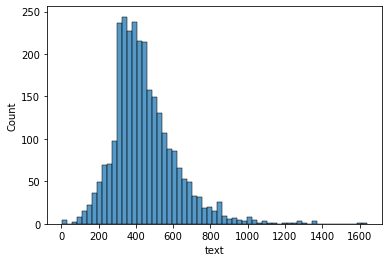

In [8]:
sns.histplot(data['text'].apply(lambda x: len(x)));

In [9]:
rows_to_remove = data['text'].apply(lambda x: len(x)).sort_values().head(5).index.to_list()
data.iloc[rows_to_remove]

,subreddit,sentence_range,text,id,label,confidence,social_karma,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,lex_liwc_posemo,lex_liwc_negemo,lex_liwc_anx,lex_liwc_anger,lex_liwc_sad,lex_liwc_social,lex_liwc_family,lex_liwc_friend,lex_liwc_female,lex_liwc_male,lex_liwc_cogproc,lex_liwc_insight,lex_liwc_cause,...,lex_liwc_percept,lex_liwc_see,lex_liwc_hear,lex_liwc_feel,lex_liwc_bio,lex_liwc_body,lex_liwc_health,lex_liwc_sexual,lex_liwc_ingest,lex_liwc_drives,lex_liwc_affiliation,lex_liwc_achieve,lex_liwc_power,lex_liwc_reward,lex_liwc_risk,lex_liwc_focuspast,lex_liwc_focuspresent,lex_liwc_focusfuture,lex_liwc_relativ,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,social_upvote_ratio,social_num_comments,domain,social_date
1592,anxiety,"[15, 20]",#NAME?,469,1,0.571429,3,9,74.89,13.32,4.97,1.0,9.0,44.44,100.00,11.11,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,11.11,0.00,11.11,0.00,0.00,0.0,0.00,11.11,0.00,11.11,0.00,0.00,11.11,0.00,0.00,0.00,0.00,0.00,11.11,11.11,0.00,...,22.22,0.00,0.00,22.22,44.44,11.11,11.11,0.0,22.22,11.11,0.00,11.11,0.00,0.00,11.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,11.11,0.0,0.0,0.0,0.0,0.0,0.0,55.56,0.00,0.00,0.0,0.0,0.0,0.0,55.56,0.0,0.00,0.0,0.0,1.00,7,anxiety,2018-01-28 04:36:40
295,domesticviolence,"(10, 15)",#NAME?,31315,0,0.800000,10,78,39.13,99.00,46.75,99.0,15.6,16.67,92.31,62.82,25.64,16.67,3.85,2.56,10.26,0.00,0.0,8.97,1.28,17.95,6.41,1.28,10.26,0.00,15.38,3.85,3.85,2.56,0.0,1.28,12.82,12.82,0.00,0.00,0.00,0.00,19.23,0.00,0.00,0.00,0.00,6.41,1.28,1.28,...,2.56,0.00,2.56,0.00,1.28,1.28,0.00,0.0,0.00,14.10,3.85,5.13,5.13,2.56,0.00,2.56,11.54,2.56,14.10,2.56,7.69,3.85,2.56,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.38,6.41,3.85,0.0,0.0,0.0,0.0,5.13,0.0,0.00,0.0,0.0,0.92,9,abuse,2017-12-08 09:21:17
2190,ptsd,"[30, 35]",#NAME?,559,1,1.000000,9,35,16.23,38.74,98.59,1.0,35.0,34.29,94.29,54.29,20.00,14.29,14.29,0.00,0.00,0.00,0.0,5.71,8.57,8.57,8.57,11.43,8.57,2.86,17.14,2.86,0.00,5.71,0.0,0.00,14.29,0.00,14.29,5.71,0.00,2.86,14.29,8.57,2.86,2.86,5.71,11.43,8.57,0.00,...,2.86,0.00,0.00,2.86,0.00,0.00,0.00,0.0,0.00,20.00,11.43,0.00,2.86,0.00,5.71,5.71,8.57,0.00,11.43,0.00,2.86,8.57,0.00,2.86,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,20.00,0.00,0.00,0.0,0.0,0.0,0.0,14.29,0.0,5.71,0.0,0.0,0.85,9,ptsd,2018-11-06 22:25:11
2563,domesticviolence,"(15, 20)",#NAME?,29201,0,0.800000,23,92,4.30,99.00,1.00,99.0,18.4,15.22,96.74,60.87,23.91,19.57,0.00,0.00,7.61,11.96,0.0,4.35,1.09,9.78,11.96,8.70,10.87,0.00,20.65,6.52,3.26,5.43,0.0,1.09,14.13,10.87,3.26,0.00,2.17,0.00,30.43,1.09,0.00,1.09,11.96,15.22,4.35,1.09,...,8.70,5.43,1.09,2.17,1.09,0.00,1.09,0.0,0.00,6.52,2.17,2.17,1.09,3.26,0.00,0.00,13.04,8.70,11.96,0.00,5.43,6.52,0.00,1.09,1.09,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,13.04,5.43,3.26,0.0,0.0,0.0,0.0,4.35,0.0,0.00,0.0,0.0,1.00,4,abuse,2018-05-25 13:55:30
854,assistance,"[10, 15]",<url> Resume: <url> Thank you! !,806,0,0.571429,16,5,51.43,99.00,1.00,99.0,5.0,0.00,60.00,20.00,20.00,20.00,0.00,0.00,20.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,0.00,0.00,0.0,0.00,20.00,20.00,0.00,0.00,0.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0

In [10]:
data.shape

(2838, 104)

In [11]:
data.drop(labels=rows_to_remove, inplace=True )
data.shape

(2833, 104)

In [12]:
data['pct_caps'] = data['text'].apply(lambda x: sum([char.isupper() for char in x])/len(x) )
data['text'] = data['text'].apply(lambda x: x.lower())

In [13]:
# fig, axs = plt.subplots(nrows=20,ncols=5,figsize=(60,60) )
# pal = sns.color_palette(palette=None, n_colors=len(X_liwc.columns))

# for (i,f,c) in zip(axs.flatten(),X_liwc.columns, pal):
#     sns.histplot(X_liwc[f], ax=i, color=c)

#### comparison on Naive Bayes using TF-iDF vs. LIWC vectorizer

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(data['text'])

y = data['label']

nb_model = MultinomialNB()

nb_model.fit(X,y)


MultinomialNB()

In [15]:
data_test.drop(columns=cols_to_remove, inplace=True)

data_test['domain'] = data_test['subreddit'].map({'domesticviolence': 'abuse',
                                                   'survivorsofabuse': 'abuse',
                                                   'anxiety': 'anxiety',
                                                   'stress': 'anxiety',
                                                   'almosthomeless': 'ﬁnancial',
                                                   'assistance': 'ﬁnancial',
                                                   'food_pantry': 'ﬁnancial',
                                                   'homeless':'ﬁnancial',
                                                   'ptsd':'ptsd',
                                                   'relationships':'social'
                                                   })

data_test['social_date'] = data_test['social_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
data_test = data_test.drop(columns='social_timestamp')

data_test['pct_caps'] = data_test['text'].apply(lambda x: sum([char.isupper() for char in x])/len(x) )
data_test['text'] = data_test['text'].apply(lambda x: x.lower())

In [16]:
y_test = data_test['label']

X_test = vectorizer.transform(data_test['text'])

nb_model.score(X_test,y_test)

0.6461538461538462

In [17]:
non_liwc_cols = ['subreddit', 
                 'sentence_range', 
                 'text', 
                 'id', 
                 'label', 
                 'confidence', 
                 'social_karma', 
                 'social_upvote_ratio',
                 'social_num_comments', 
                 'domain', 
                 'social_date',
                 'pct_caps']

X_liwc = data.drop(columns=non_liwc_cols) 
nb_model1 = MultinomialNB()
nb_model1.fit(X_liwc,y)

MultinomialNB()

In [18]:
X_liwc_test = data_test.drop(columns=non_liwc_cols)
nb_model1.score(X_liwc_test,y_test)

0.7412587412587412

In [19]:
log_reg_drop =  ['subreddit', 
                 'sentence_range', 
                 'text', 
                 'id', 
                 'label', 
                 'confidence',
                 'social_date',
                 'domain']
log_reg_X = data.drop(columns= log_reg_drop)

In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=10_000)

log_reg.fit(X=X_liwc, y=data['label'], sample_weight=data['confidence'])

LogisticRegression(max_iter=10000)

In [21]:
log_reg.score(X_liwc_test,y_test)

0.7426573426573426

In [22]:
log_reg1 = LogisticRegression(max_iter=10_000)

log_reg1.fit(X=log_reg_X, y=data['label'], sample_weight=data['confidence'])

LogisticRegression(max_iter=10000)

In [23]:
log_reg_X_test = data_test.drop(columns=log_reg_drop)
log_reg1.score(log_reg_X_test,y_test)

0.7468531468531469

## Feature Selection

In [24]:
data.shape

(2833, 105)

In [25]:
data['id'].nunique()
data.set_index('id',inplace=True)

In [26]:
data['domain_label'] = data['domain'].map({'ptsd':1,
                                           'ﬁnancial':2,
                                           'social':3,
                                           'abuse':4,
                                           'anxiety':5
                                            })



In [27]:
eda_data = data.drop(columns=['text','subreddit','domain'])
eda_data.head(2)
all_features = eda_data.drop(columns=['label','domain_label','confidence', 'sentence_range','social_date' ])
all_features

,social_karma,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,lex_liwc_posemo,lex_liwc_negemo,lex_liwc_anx,lex_liwc_anger,lex_liwc_sad,lex_liwc_social,lex_liwc_family,lex_liwc_friend,lex_liwc_female,lex_liwc_male,lex_liwc_cogproc,lex_liwc_insight,lex_liwc_cause,lex_liwc_discrep,lex_liwc_tentat,lex_liwc_certain,lex_liwc_differ,lex_liwc_percept,lex_liwc_see,lex_liwc_hear,lex_liwc_feel,lex_liwc_bio,lex_liwc_body,lex_liwc_health,lex_liwc_sexual,lex_liwc_ingest,lex_liwc_drives,lex_liwc_affiliation,lex_liwc_achieve,lex_liwc_power,lex_liwc_reward,lex_liwc_risk,lex_liwc_focuspast,lex_liwc_focuspresent,lex_liwc_focusfuture,lex_liwc_relativ,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,social_upvote_ratio,social_num_comments,pct_caps
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33181,5,116,72.64,15.04,89.26,1.00,29.00,12.93,87.07,56.03,16.38,12.07,9.48,0.00,0.86,1.72,0.00,4.31,3.45,19.83,7.76,5.17,4.31,1.72,16.38,6.03,3.45,0.86,1.72,1.72,8.62,1.72,6.90,0.86,2.59,3.45,3.45,0.00,0.00,0.00,1.72,11.21,3.45,0.86,2.59,5.17,0.00,2.59,6.03,1.72,1.72,1.72,2.59,0.86,1.72,0.00,0.00,8.62,0.00,1.72,4.31,0.86,2.59,4.31,11.21,0.86,17.24,0.86,10.34,6.03,0.86,0.00,0.00,0.00,2.59,0.00,0.86,0.86,0.00,0.00,0.00,0.0,21.55,9.48,3.45,0.86,0.86,0.00,0.0,0.00,5.17,1.72,0.00,0.00,0.86,1,0.084063
2606,4,109,79.08,76.85,56.75,98.18,27.25,21.10,87.16,48.62,11.93,7.34,1.83,2.75,2.75,0.00,0.00,4.59,8.26,13.76,6.42,3.67,8.26,0.92,15.60,2.75,0.92,0.92,2.75,0.92,5.50,5.50,0.00,0.00,0.00,0.00,11.01,0.00,0.00,0.00,0.00,11.93,1.83,0.00,3.67,5.50,1.83,6.42,0.92,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.60,5.50,3.67,7.34,2.75,0.00,0.92,13.76,0.92,15.60,2.75,10.09,1.83,11.01,0.00,0.00,0.92,0.00,0.00,1.83,0.00,0.92,0.00,0.00,0.0,14.68,4.59,2.75,0.00,0.00,0.00,0.0,0.00,0.00,2.75,0.92,3.67,0.65,2,0.037415
38816,2,167,33.80,76.38,86.24,25.77,33.40,17.37,91.02,61.68,25.15,16.17,8.98,1.80,1.80,2.99,0.60,8.98,5.39,12.57,10.18,1.80,5.99,1.20,20.96,1.20,0.60,0.60,1.20,1.80,2.40,1.20,1.20,0.00,0.00,0.00,15.57,0.60,3.59,1.80,2.40,10.18,4.19,1.20,0.60,2.99,0.00,1.80,0.00,0.00,0.00,0.00,0.60,0.60,0.00,0.00,0.00,8.98,5.39,0.60,1.20,2.40,0.00,3.59,14.37,1.80,16.17,4.79,5.99,5.39,0.00,1.20,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,10.78,2.40,3.59,0.00,0.00,0.60,0.0,0.00,2.40,1.80,0.00,0.00,0.67,0,0.012987
239,0,273,2.98,15.25,95.42,79.26,54.60,8.06,98.90,65.57,30.40,23.44,16.12,0.37,0.37,6.59,0.00,6.96,3.30,9.16,8.79,6.59,9.89,3.66,20.88,3.66,1.83,1.10,0.00,1.10,8.79,5.86,2.93,0.00,0.37,0.73,13.55,0.37,1.10,0.37,8.06,16.85,7.69,0.73,1.83,1.83,1.47,4.76,7.33,1.10,0.00,5.49,2.20,0.00,0.00,0.37,0.37,6.59,4.03,0.00,0.73,1.10,0.73,7.69,13.19,1.10,10.99,1.83,3.30,6.23,0.73,0.37,0.37,0.00,0.00,0.00,2.56,0.00,0.73,0.73,0.00,0.0,12.09,2.56,7.33,0.00,0.00,0.00,0.0,0.00,1.47,0.00,0.73,0.00,0.50,5,0.009397
1421,24,89,32.22,28.71,84.01,1.00,17.80,31.46,88.76,52.81,15.73,11.24,7.87,0.00,0.00,3.37,0.00,4.49,4.49,8.99,13.48,4.49,4.49,2.25,13.48,4.49,2.25,1.12,1.12,1.12,7.87,0.00,7.87,1.12,4.49,0.00,8.99,0.00,0.00,0.00,4.49,11.24,3.37,2.25,0.00,0.00,1.12,4.49,2.25,0.00,0.00,2.25,2.25,0.00,1.12,1.12,0.00,7.87,0.00,2.25,4.49,0.00,1.12,5.62,6.74,0.00,14.61,2.25,2.25,10.11,1.12,0.00,2

In [28]:
from sklearn.feature_selection import mutual_info_classif

MI = mutual_info_classif(all_features,data['label'])

In [29]:
headers = all_features.columns

In [30]:
MI_vars = pd.Series(index=headers, data=MI).sort_values(ascending=False)

In [31]:
MI_vars_selected = MI_vars[MI_vars>0]
MI_vars_selected.shape

(75,)

In [32]:
features_post_MI = all_features[MI_vars_selected.index]

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

    return vif

In [34]:
VIF_df = calc_vif(features_post_MI)

In [35]:
VIF_df.sort_values(by='VIF', ascending=True, inplace=True )
VIF_vars_selected = VIF_df[VIF_df['VIF']<15]
VIF_vars_selected.shape

(51, 2)

In [36]:
features_post_VIF = features_post_MI[VIF_vars_selected['variables']]

In [37]:
corr= features_post_VIF.corr()
df_s = corr.copy()

def style_negative(v, props=''):
    return props if v < 0 else None
s=df_s.style.applymap(style_negative, props='color:red;')\
              .applymap(lambda v: 'opacity: 20%;' if (v < 0.5) and (v > -0.5) else None)
s


,lex_liwc_OtherP,lex_liwc_nonflu,lex_liwc_QMark,lex_liwc_Colon,lex_liwc_Dash,lex_liwc_Parenth,lex_liwc_home,lex_liwc_sexual,lex_liwc_leisure,lex_liwc_money,lex_liwc_swear,lex_liwc_friend,lex_liwc_focusfuture,lex_liwc_number,lex_liwc_risk,lex_liwc_sad,lex_liwc_work,lex_liwc_body,lex_liwc_Comma,lex_liwc_interrog,social_karma,social_num_comments,lex_liwc_cause,lex_liwc_anx,lex_liwc_quant,lex_liwc_you,lex_liwc_motion,lex_liwc_discrep,lex_liwc_anger,lex_liwc_health,lex_liwc_female,lex_liwc_we,lex_liwc_adj,lex_liwc_Apostro,lex_liwc_power,lex_liwc_male,lex_liwc_tentat,lex_liwc_negate,lex_liwc_Period,lex_liwc_see,lex_liwc_insight,lex_liwc_hear,lex_liwc_Tone,lex_liwc_bio,lex_liwc_adverb,lex_liwc_WPS,lex_liwc_focuspast,lex_liwc_affiliation,lex_liwc_time,lex_liwc_Sixltr,lex_liwc_feel
lex_liwc_OtherP,1.000000,-0.017221,0.085987,0.137949,0.149639,0.062957,-0.013459,-0.017105,0.023217,0.092247,-0.022534,0.017606,-0.004371,0.026231,-0.023629,-0.013277,0.057804,0.005307,-0.002611,0.031230,-0.010702,0.002808,0.023520,-0.039629,-0.007283,0.107641,0.002291,0.026159,-0.042315,-0.018771,-0.032447,0.000423,-0.038770,-0.033973,0.004690,-0.030397,0.010048,-0.049144,-0.043362,-0.021742,-0.023364,-0.011746,0.091174,0.003412,-0.049840,0.000563,-0.072621,0.056524,-0.068009,0.037599,-0.015647
lex_liwc_nonflu,-0.017221,1.000000,-0.014000,-0.039760,-0.006002,0.002901,-0.010450,0.014472,-0.002514,-0.004234,0.072934,-0.000549,-0.001215,-0.019423,0.038205,-0.022773,0.019419,-0.003455,0.047741,0.018083,0.017955,0.013835,-0.007686,-0.016657,-0.001561,0.011152,-0.004935,-0.023718,0.044990,0.031182,-0.008377,0.012719,0.051953,-0.019851,-0.026307,-0.006954,-0.045678,-0.015685,0.011764,-0.027197,-0.017036,-0.009882,0.070711,0.019737,0.141189,-0.004489,0.027667,-0.023118,0.012475,-0.004140,-0.011155
lex_liwc_QMark,0.085987,-0.014000,1.000000,0.030453,0.037228,-0.012454,-0.046972,-0.006088,-0.006468,-0.044643,0.003730,-0.004435,-0.003420,-0.065970,0.003614,-0.006987,-0.036603,0.010360,-0.043767,0.211681,-0.011163,0.001891,0.042059,-0.002971,-0.031340,0.045997,-0.022213,0.044038,0.004164,-0.016641,-0.037923,-0.048123,-0.005027,-0.004431,-0.017899,-0.025821,0.084706,-0.001532,-0.068867,-0.006266,0.036712,-0.027651,0.022594,-0.001483,0.050112,-0.093036,-0.067482,-0.037328,-0.072249,-0.037220,0.041884
lex_liwc_Colon,0.137949,-0.039760,0.030453,1.000000,0.171835,0.234838,-0.032699,-0.033785,0.022579,0.042772,-0.053922,0.031828,0.016763,0.120981,-0.020762,0.032839,0.112601,-0.010185,0.108009,0.038194,0.000748,0.027886,0.047412,-0.037738,0.050770,0.109313,-0.030890,0.015802,-0.044576,-0.004003,-0.010533,0.016333,-0.036450,-0.048114,0.074537,-0.049186,0.010593,-0.059732,-0.049404,-0.039931,-0.013225,-0.013001,0.067392,-0.032987,-0.068203,-0.034506,-0.136602,0.090128,-0.061991,0.111820,-0.059808
lex_liwc_Dash,0.149639,-0.006002,0.037228,0.171835,1.000000,0.017138,0.003203,0.007698,0.035207,0.029959,-0.047191,0.055277,0.007406,0.125114,-0.027665,-0.034997,0.008804,-0.033956,0.000439,-0.000442,0.005861,0.055502,-0.000714,-0.039910,0.003909,0.001625,-0.034553,0.021075,-0.065649,0.006870,-0.000945,0.004741,-0.003845,-0.023481,0.071698,-0.003254,0.011508,-0.047348,-0.053958,-0.010542,-0.046292,-0.032132,0.060926,0.102007,-0.093988,-0.014846,-0.101908,0.071395,-0.050612,0.133613,-0.026069
lex_liwc_Parenth,0.062957,0.002901,-0.012454,0.234838,0.017138,1.000000,0.027623,-0.008269,0.088703,0.053591,-0.023191,0.024404,-0.027057,0.161620,-0.045510,-0.015376,0.104178,0.000722,0.089248,-0.019230,-0.002389,0.005474,0.042059,-0.043496,-0.014508,0.007612,-0.030862,-0.023995,-0.032001,-0.000345,0.025311,0.035494,0.027070,-0.059666,-0.005345,0.033877,0.006904,-0.081386,-0.103186,-0.025654,-0.060160,-0.038695,0.053948,0.002246,-0.029315,0.102970,-0.024210,0.065053,0.008194,0.106426,-0.042883
lex_liwc_home,-0.013459,-0.010450,-0.046972,-0.032699,0.003203,0.027623,1.000000,-0.010315,0.173477,0.127153,0.017093,0.035510,-0.020767,0.009677,-0.026981,-0.006286,-0.030803,0.038180,0.001125,-0.063349,0.0

In [38]:
# pal=sns.diverging_palette(150, 10 ,s=90, l=25, as_cmap=True)
# plt.figure(figsize=(20,20))
# sns.heatmap(features_post_VIF.corr(), vmin=-1, vmax=1, cmap='coolwarm' );

In [39]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(4)

,feature_1,feature_2,correlation
1041,social_karma,social_num_comments,0.794533
1091,social_num_comments,social_karma,0.794533
2428,lex_liwc_affiliation,lex_liwc_we,0.684425
1628,lex_liwc_we,lex_liwc_affiliation,0.684425


In [40]:
MI_vars[corr_df.head(4)['feature_1'].to_list()]

social_karma            0.002405
social_num_comments     0.009070
lex_liwc_affiliation    0.012666
lex_liwc_we             0.026688
dtype: float64

In [41]:
features_post_VIF['social_karma'].sort_values(ascending=False).head(50)

id
26737    1435
712      1435
167      1271
30252    1189
2330     1189
12226    1122
16802    1122
70        896
7446      822
727       572
48237     547
42090     535
16668     532
22262     487
27972     487
17541     467
3674      457
48068     435
38        428
6163      412
23898     412
1196      391
17624     389
2232      376
21427     328
53650     316
2354      316
39029     314
679       299
2429      299
1766      296
1765      294
19691     287
838       287
18677     284
151       284
75        284
1764      284
50669     284
18802     284
975       269
717       261
1691      260
18360     213
1532      211
48419     211
1789      206
44772     202
29332     201
48351     198
Name: social_karma, dtype: int64

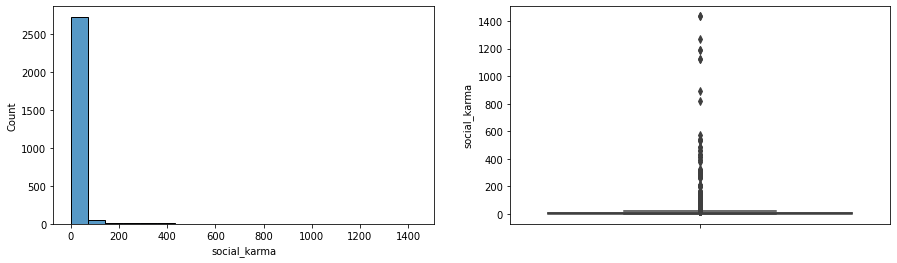

In [42]:
fig, axs = plt.subplots(1,2,figsize=(15,4))

sns.histplot(x=features_post_VIF['social_karma'],ax=axs[0], bins=20)
sns.boxplot(y=features_post_VIF['social_karma'], ax=axs[1]);

In [43]:
#we decide to cap at 200 as not many observations above that value
features_post_VIF['social_karma_cap'] = features_post_VIF['social_karma'].apply(lambda x: 200 if x>200 else x)

/var/folders/f2/9xrxtpw920x5zr_wkns47k_h0000gn/T/ipykernel_40406/3047159839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_post_VIF['social_karma_cap'] = features_post_VIF['social_karma'].apply(lambda x: 200 if x>200 else x)


In [44]:
features_post_VIF['social_num_comments'].sort_values(ascending=False).head(20)
#we decide to cap at 200 as not many observations above that value

id
167      416
712      318
26737    318
12226    292
16802    292
838      287
17541    276
17624    259
727      178
7446     164
27972    158
22262    158
1637     135
1789     134
2330     131
30252    131
19691    123
2354     110
53650    110
70       107
Name: social_num_comments, dtype: int64

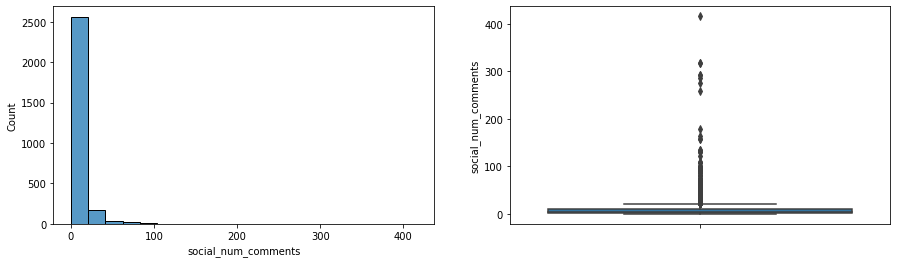

In [45]:
fig, axs = plt.subplots(1,2,figsize=(15,4))

sns.histplot(x=features_post_VIF['social_num_comments'],ax=axs[0], bins=20)
sns.boxplot(y=features_post_VIF['social_num_comments'], ax=axs[1]);

In [46]:
features_post_VIF['social_num_comments_cap'] = features_post_VIF['social_num_comments'].apply(lambda x: 100 if x>100 else x)

/var/folders/f2/9xrxtpw920x5zr_wkns47k_h0000gn/T/ipykernel_40406/3118160077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_post_VIF['social_num_comments_cap'] = features_post_VIF['social_num_comments'].apply(lambda x: 100 if x>100 else x)


In [47]:
features_post_VIF.head(2)

,lex_liwc_OtherP,lex_liwc_nonflu,lex_liwc_QMark,lex_liwc_Colon,lex_liwc_Dash,lex_liwc_Parenth,lex_liwc_home,lex_liwc_sexual,lex_liwc_leisure,lex_liwc_money,lex_liwc_swear,lex_liwc_friend,lex_liwc_focusfuture,lex_liwc_number,lex_liwc_risk,lex_liwc_sad,lex_liwc_work,lex_liwc_body,lex_liwc_Comma,lex_liwc_interrog,social_karma,social_num_comments,lex_liwc_cause,lex_liwc_anx,lex_liwc_quant,lex_liwc_you,lex_liwc_motion,lex_liwc_discrep,lex_liwc_anger,lex_liwc_health,lex_liwc_female,lex_liwc_we,lex_liwc_adj,lex_liwc_Apostro,lex_liwc_power,lex_liwc_male,lex_liwc_tentat,lex_liwc_negate,lex_liwc_Period,lex_liwc_see,lex_liwc_insight,lex_liwc_hear,lex_liwc_Tone,lex_liwc_bio,lex_liwc_adverb,lex_liwc_WPS,lex_liwc_focuspast,lex_liwc_affiliation,lex_liwc_time,lex_liwc_Sixltr,lex_liwc_feel,social_karma_cap,social_num_comments_cap
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33181,0.00,0.0,0.0,0.86,0.0,0.00,0.0,0.0,0.0,0.00,0.86,0.0,0.86,1.72,2.59,3.45,0.86,0.86,3.45,0.86,5,1,0.86,0.86,1.72,0.86,0.86,2.59,2.59,1.72,0.0,0.00,6.03,1.72,4.31,1.72,5.17,1.72,9.48,1.72,3.45,1.72,1.00,2.59,5.17,29.00,4.31,0.0,6.03,12.93,1.72,5,1
2606,3.67,0.0,0.0,0.00,0.0,0.92,0.0,0.0,0.0,0.92,0.00,0.0,0.92,2.75,0.00,0.00,11.01,0.00,2.75,0.92,4,2,0.00,0.00,0.92,2.75,2.75,3.67,0.00,0.00,0.0,2.75,2.75,2.75,7.34,0.00,5.50,0.92,4.59,0.92,1.83,0.00,98.18,0.00,3.67,27.25,0.92,5.5,1.83,21.10,0.00,4,2


### Min Max Scalling 

In [48]:
from sklearn.preprocessing import MinMaxScaler

In [49]:
scaler = MinMaxScaler()

In [50]:
features_post_VIF.drop(columns=['social_num_comments', 'social_karma'], inplace=True)

/var/folders/f2/9xrxtpw920x5zr_wkns47k_h0000gn/T/ipykernel_40406/1312426246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_post_VIF.drop(columns=['social_num_comments', 'social_karma'], inplace=True)


In [51]:
X_scaled_array = scaler.fit_transform(features_post_VIF)

In [52]:
df_X_scaled = pd.DataFrame(columns = features_post_VIF.columns,
                           index = features_post_VIF.index,
                           data = X_scaled_array)

In [53]:
df_X_scaled.shape

(2833, 51)

In [54]:
smf_data = df_X_scaled.join(data['label'])

### Statsmodels

In [55]:
smf_log_reg_results = smf.ols(formula = 'label' + " ~ " +  " + ".join(smf_data.columns[:-1]), data=smf_data).fit().summary()

In [97]:
 smf_log_reg_results.tables[0]

Dep. Variable:,label,R-squared:,0.326
Model:,OLS,Adj. R-squared:,0.313
Method:,Least Squares,F-statistic:,26.34
Date:,"Sat, 19 Feb 2022",Prob (F-statistic):,4.81e-198
Time:,17:28:58,Log-Likelihood:,-1494.5
No. Observations:,2833,AIC:,3093.
Df Residuals:,2781,BIC:,3402.
Df Model:,51,,
Covariance Type:,nonrobust,,


In [106]:
 smf_log_reg_results.tables[2]

Omnibus:,385.121,Durbin-Watson:,1.980
Prob(Omnibus):,0.000,Jarque-Bera (JB):,102.888
Skew:,-0.129,Prob(JB):,4.55e-23
Kurtosis:,2.103,Cond. No.,64.7


In [101]:
results_as_html = smf_log_reg_results.tables[1].as_html()
smf_results = pd.read_html(results_as_html, header=0, index_col=0)[0]
smf_results[smf_results['P>|t|']<0.05].sort_values(by='P>|t|')

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6446,0.070,9.270,0.000,0.508,0.781
lex_liwc_Sixltr,-0.4162,0.109,-3.823,0.000,-0.630,-0.203
lex_liwc_focuspast,-0.2727,0.059,-4.594,0.000,-0.389,-0.156
lex_liwc_Tone,-0.3029,0.030,-10.110,0.000,-0.362,-0.244
lex_liwc_female,-0.2623,0.053,-4.963,0.000,-0.366,-0.159
lex_liwc_feel,0.4280,0.091,4.696,0.000,0.249,0.607
lex_liwc_you,-0.7530,0.109,-6.936,0.000,-0.966,-0.540
lex_liwc_anx,0.8266,0.156,5.294,0.000,0.520,1.133
social_karma_cap,-0.2647,0.075,-3.541,0.000,-0.411,-0.118
lex_liwc_sad,0.3414,0.098,3.490,0.000,0.150,0.533


In [104]:
sign_feat_list = smf_results[smf_results['P>|t|']<0.05].sort_values(by='P>|t|').index
sign_feat_list[1:] #exclude the intercept

Index(['lex_liwc_Sixltr', 'lex_liwc_focuspast', 'lex_liwc_Tone',
       'lex_liwc_female', 'lex_liwc_feel', 'lex_liwc_you', 'lex_liwc_anx',
       'social_karma_cap', 'lex_liwc_sad', 'lex_liwc_home', 'lex_liwc_WPS',
       'lex_liwc_adverb', 'lex_liwc_Comma', 'lex_liwc_we', 'lex_liwc_health',
       'lex_liwc_anger', 'lex_liwc_risk', 'lex_liwc_negate',
       'lex_liwc_Apostro', 'lex_liwc_swear', 'lex_liwc_leisure',
       'lex_liwc_adj', 'lex_liwc_see', 'lex_liwc_QMark', 'lex_liwc_bio',
       'lex_liwc_quant', 'lex_liwc_sexual'],
      dtype='object')

In [ ]:
#remaining from the Descision Science section 
#- check the p-values and build a story 
#- word clouds by domain or by label or both (domain makes sense as people will talk differently)
#-visualize the distributions of the variables left after statsmodels - label 0 vs 1 
# -- visualize the ones with outliers (social vars) on log scale if needed

In [ ]:
# #Wordcloud
# order_reviews_c=data['order_reviews'].copy()

# bad_reviews = order_reviews_c[(order_reviews_c['review_score']\
#                                  .isin([1,2,3])) & (~order_reviews_c['review_comment_message'].isna())]\
#                                  ['review_comment_message']

# text = """ """.join(bad_reviews.to_list()) 
# wordcloud = WordCloud(max_font_size=100, max_words=50, background_color="white").generate(text)

# plt.figure(figsize=(15,12))
# plt.title('Word cloud from negative reviews', {'fontsize':20, 'color':'black'})
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

In [ ]:
# word clouds by domain - ML iteration

In [ ]:
# visualizations of the predictive vars - hopefully quite distinct distrbutions and we can inrepret the coefficients

In [ ]:
#permutation importances ... check that out as well....feature_permutation, Lasso, Ridge